In [2]:
import os
import gc
import re
import string
import numpy as np
import pandas as pd
import kagglehub
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Custom lightweight serializer
import python.lightweight_serializer as tflws

In [3]:
# Assign home_dir as a local directory to use when saving data to disk.
home_dir = os.getenv("home_BA885")

if not home_dir:
    home_dir = os.getcwd()
# Colab home
# home_dir = "/content"

# Neural Machine Translation

Author: Nima Doroud

In the previous notebook, we discussed the embedding of natural language as sequences of vectors in the embedding space. Our next task is to design model architectures that take such sequences as inputs and perform our desired task, be it classification, such as sentiment analysis of movie reviews, or text generation such as machine translation.

The subject of this notebook Neural Machine Translation (NMT), a class of Sequence to sequence (Seq2sec) models where both the input and output are sequences of vectors. Specifically, we will focus on (sentence level) Neural Machine Translation (NMT) models capable of translating text from one language (source) to another (target).

The most common Seq2seq models adopt the Encoder-Decoder architecture which schematically acts as follows:

**Input sequence -> Encoder -> Latent vector -> Decoder -> Output sequence**

The task of the encoder is to capture the "most relevant features" of the input sequence which it encodes in the latent vector. To enforce this "distillation" the latent vector lives in a lower-dimensional space as compared to the input. Meanwhile, the decoder is tasked with generating a new sequence using the latent vector as the prompt.

For a machine translation model, we expect the encoder block to capture features such as context/meaning, tense, sentiment, and so on, while ignoring language specific features such as the detailed grammar rules of the source language. The decoder then uses these features to generate a new sentence while adhering to the grammar rules of the target language.

The encoder/decoder blocks deal with sequences and thus need to correctly capture both the context and the order of a sequence. Two common architectures designed for this purpose are recurrent neural networks (RNN), in which the ordered nature of the sequence is manifest, and transformer neural networks which utilize "attention" to better identify context. Below, we will build both RNN and transformer based NMT models.

## Bilingual Sentence Pairs

We will use a dataset containing pairs of sentences in two languages from <a href="https://tatoeba.org/">Tatoeba Project</a>. You can take your pick from the many pairs of languages they have available, here we will use the Spanish-English dataset.

In [4]:
# Download dataset
if not os.path.exists(home_dir+'/datasets/spa-eng/spa.txt'):
    ds_link = 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
    tf.keras.utils.get_file('spa-eng.zip', 
                            ds_link, 
                            cache_dir='./',
                            cache_subdir='datasets',
                            extract=True)

In [5]:
# Import the dataset from the tab ('\t') seperated file, make sure to skip the bad lines.
df = pd.read_csv(home_dir+'/datasets/spa-eng/spa.txt',
                 header = None,
                 sep = '\t',
                 on_bad_lines='skip')

# Label the columns with English and Spanish sentences as 'en' and 'es', respectively.
df = df.rename(columns={0:'en', 1:'es'})

# Shuffle the dataset.
df = df.sample(frac=1, random_state=1).reset_index(drop=True)

In [6]:
# Print the first few rows
print('Number of rows = {}'.format(df.shape[0]))
df.head(4)

Number of rows = 118964


,en,es
0,We need to chat soon.,Necesitamos charlar pronto.
1,She married a musician.,Se casó con un músico.
2,Do it right now.,Hazlo ahoritita.
3,This is the ticket line.,Esta es la cola para sacar los billetes.


### Standardization

In [8]:
# Create a string of all the charachters to strip from the dataset.
# Make sure to exclude the square brackets "[" and "]"  as we will be
# using them in markers to mark the beginning and end of sentences in 
# the target language (English).

strip_chars = string.punctuation+'¿¡'
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

print(f'The following charachters will be striped: {strip_chars} \n')

# Escape the special charachters via the regular expression package.
# The square brackets indicate that there are multiple patterns.
strip_chars = '['+re.escape(strip_chars)+']'

# Define a standardization function for the text dataset.
def custom_standardization(input_str):
    '''Standardizes an input string or tensor of strings by
    convering all the charachters to lower case and striping
    the charachters in strip_chars. Returns a string valued
    tf.tensor.
    '''
    return tf.strings.regex_replace(tf.strings.lower(input_str), strip_chars, "")

print('Here is the reslut of standardization of the first few Spanish sentences: \n')
pd.DataFrame(
    np.concatenate(
        (df.loc[20:24,['es']], custom_standardization(df.loc[20:24,['es']]).numpy()),
        axis=1), columns = ['Original', 'Standardized'])

The following charachters will be striped: !"#$%&'()*+,-./:;<=>?@\^_`{|}~¿¡ 

Here is the reslut of standardization of the first few Spanish sentences: 



,Original,Standardized
0,¿Puedes caminar?,b'puedes caminar'
1,Tom es mi padre.,b'tom es mi padre'
2,Tenemos que acordarnos de recoger a Tom en la ...,b'tenemos que acordarnos de recoger a tom en l...
3,No quiero oír más excusas.,b'no quiero o\xc3\xadr m\xc3\xa1s excusas'
4,Le seguí a ella hasta la habitación.,b'le segu\xc3\xad a ella hasta la habitaci\xc3...


In [9]:
# Add markers at the beginning and the end of every sentence in the target dataset.
def en_sentence_marker(row: pd.Series) -> pd.Series:
    '''Adds start and end markers to every string in a string valued
    pandas.Series object. For English sentences, the start marker will
    be '[start]' and the end marker '[end]'.
    '''
    return '[start] '+row+' [end]'

# Create new columns for standardized English and Spanish sentences.
# Make sure to mark the English (target) sentences.
df['en_s'] = custom_standardization(df.en.apply(en_sentence_marker)).numpy()
df['es_s'] = custom_standardization(df.es).numpy()

df.head(4)

,en,es,en_s,es_s
0,We need to chat soon.,Necesitamos charlar pronto.,b'[start] we need to chat soon [end]',b'necesitamos charlar pronto'
1,She married a musician.,Se casó con un músico.,b'[start] she married a musician [end]',b'se cas\xc3\xb3 con un m\xc3\xbasico'
2,Do it right now.,Hazlo ahoritita.,b'[start] do it right now [end]',b'hazlo ahoritita'
3,This is the ticket line.,Esta es la cola para sacar los billetes.,b'[start] this is the ticket line [end]',b'esta es la cola para sacar los billetes'


In [10]:
# Split the dataset into train, validation and test datasets.
valid_df = df.loc[np.floor(df.shape[0]*0.8)-1 : np.floor(df.shape[0]*0.9)-1]
test_df = df.loc[np.floor(df.shape[0]*0.9) :]
df = df.loc[:np.floor(df.shape[0]*0.8)-2]

print(f'Total number of enteries: {df.shape[0]+valid_df.shape[0]+test_df.shape[0]}')
print(f'Numper of training samples: {df.shape[0]}')
print(f'Numper of validation samples: {valid_df.shape[0]}')
print(f'Numper of test samples: {test_df.shape[0]}')

Total number of enteries: 118964
Numper of training samples: 95170
Numper of validation samples: 11897
Numper of test samples: 11897


### Vectorization

Our NMT model will be tailored to translate relatively short sentences given our training dataset. As such we will set a maximum length for input and output sentences which will be imposed by the vectorization layers.

Thus, we will analyze the training dataset to find suitable parameters for the vectorization layers.

In [11]:
# Find the number of unique tokens in each language in the training dataset
print('\nNumber of unique English tokens in the training dataset = ',
      tf.unique(tf.strings.split(df.en_s, ' ').flat_values)[0].__len__())

print('\nNumber of unique Spanish tokens in the training dataset = ',
      tf.unique(tf.strings.split(df.es_s, ' ').flat_values)[0].__len__())

# Find a reasonable cutoff length for sentences
print('\nSentence length quantiles for each language in the dataset:')
pd.DataFrame(
    tf.strings.split(df[['en_s','es_s']], ' ').row_lengths(axis=2).numpy()
).quantile([0.5,0.9, 1.0]).rename(columns={0:'en', 1:'es'})


Number of unique English tokens in the training dataset =  12622

Number of unique Spanish tokens in the training dataset =  23860

Sentence length quantiles for each language in the dataset:


,en,es
0.5,8.0,6.0
0.9,12.0,10.0
1.0,37.0,42.0


In [12]:
# Set the size of the vocabulary as well as the cutoff length of sentences.
# Recall that our English sentences have markers and we do not care if the
# [end] marker is dropped because of the cutoff.
en_vocab_size = 12000
en_seq_length = 16

es_vocab_size = 20000
es_seq_length = 16

# Create a vectorization layer for the English dataset.
en_vectorization = layers.TextVectorization(
    max_tokens=en_vocab_size,
    output_mode="int",
    output_sequence_length=en_seq_length,
    standardize=None,
    name=f"en_vectorization_{en_vocab_size}_{en_seq_length}")

# Create a vectorization layer for the Spanish dataset.
es_vectorization = layers.TextVectorization(
    max_tokens=es_vocab_size,
    output_mode="int",
    output_sequence_length=es_seq_length,
    standardize=None,
    name=f"es_vectorization_{es_vocab_size}_{es_seq_length}")

# Load or adapt the vectorization layers vocabularies.
if os.path.exists(home_dir+'/datasets/spa-eng/en_vocab.csv'):
    en_vectorization.set_vocabulary(list(pd.read_csv(
        home_dir+'/datasets/spa-eng/en_vocab.csv',
        header=None).fillna('')[0]))
else:
    en_vectorization.adapt(df.en_s)

if os.path.exists(home_dir+'/datasets/spa-eng/es_vocab.csv'):
    es_vectorization.set_vocabulary(list(pd.read_csv(
        home_dir+'/datasets/spa-eng/es_vocab.csv',
        header=None).fillna('')[0]))
else:
    es_vectorization.adapt(df.es_s)

In [13]:
# Save vocabulary to disk
if not os.path.exists(home_dir+'/datasets/spa-eng/en_vocab.csv'):
    pd.DataFrame(en_vectorization.get_vocabulary()).to_csv(
        home_dir+'/datasets/spa-eng/en_vocab.csv',
        header=False,
        index=False)
if not os.path.exists(home_dir+'/datasets/spa-eng/es_vocab.csv'):
    pd.DataFrame(es_vectorization.get_vocabulary()).to_csv(
        home_dir+'/datasets/spa-eng/es_vocab.csv',
        header=False,
        index=False)

In [14]:
# The vectors can be reverted back into text via a dictionary that maps
# the indices to the vocabulary.
en_vocabulary = en_vectorization.get_vocabulary()
en_vocabulary = dict(zip(range(len(en_vocabulary)), en_vocabulary))

es_vocabulary = es_vectorization.get_vocabulary()
es_vocabulary = dict(zip(range(len(es_vocabulary)), es_vocabulary))

def decode_en_vector(en_vector):
    '''Transforms a vectorized English sentence back to
    English text using the recorded vocabulary.
    Returns a string.
    '''
    en_str = ''
    for i in range(en_seq_length):
        en_str += en_vocabulary[en_vector[i]]+' '
        if en_vector[i] == 0:
            break
    return en_str.rstrip()

def decode_es_vector(es_vector):
    '''Transforms a vectorized Spanish sentence back to
    Spanish text using the recorded vocabulary.
    Returns a string.
    '''
    es_str = ''
    for i in range(es_seq_length):
        es_str += es_vocabulary[es_vector[i]]+' '
        if es_vector[i] == 0:
            break
    return es_str.rstrip()

### Sequence to sequence dataset

Our Seq2seq models generate the output sentence one token at a time. Therefore, we need to prepare our (sample, label) datasets to match each sample = (source, target[:-1]) with a sequence of labels = [target[k] for k in range(1,n)] where n is the length of the tokenized target sentence.

In [15]:
# Set the batch size
batch_size = 256

# Set parallelization parameter
num_cores = 12

# Define a function to map the sentences (source, target) to 
# ((source, target[:-1]), [vectorize(target[k]) for k in range(1,n)])
def tokenwise_seqs(source, target):
    ''' Maps a pair of sentences (strings) to a tuple of
    ((source, target[:-1]), [vectorize(target[k]) for k in range(1,n)]).
    Use with dataset.map().
    '''
    partial_target = tf.strings.regex_replace(target, ' \[end\]', '')
    next_target = tf.strings.regex_replace(target, '\[start\] ', '')
    next_target = en_vectorization(next_target)
    return ( (source, partial_target), next_target )

# Define a function to prepare our dataset
def tokenwise_dataset(source, target):
    ''' Creates a tf.data.Dataset object from pairs of source, target
    strings. The dataset elements are mapped to take the following form:
    ((source, target[:-1]), [vectorize(target[k]) for k in range(1,n)])
    '''
    ds = tf.data.Dataset.from_tensor_slices((source, target)).batch(batch_size)
    ds = ds.map(tokenwise_seqs, num_parallel_calls=num_cores)
    return ds.shuffle(512).prefetch(128).cache()

# Prepare the training, validation and test datasets
ds_train = tokenwise_dataset(df.es_s, df.en_s)
ds_valid = tokenwise_dataset(valid_df.es_s, valid_df.en_s)
ds_test = tokenwise_dataset(test_df.es_s, test_df.en_s)

## Encoder-Decoder model

To build our NMT models, we start by implementing the skeleton of the encoder-decoder architecture as a keras.Model. The model glues together an encoder and a decoder such that the output of the encoder, a vector or a sequence of vectors in the latent space for each input sentence, is passed on to the decoder as an input (initial state). We also implement an inference function so as to produce the full predicted output sequence.

To illustrate how inference should be implemented, consider a single call of the model with inputs=[source, target[:k]] where source is the source sentence and target[:k] is the first k tokens of the target sentence. With the above input, the model will predict the next token in the target sequence. Thus, the full inference (model.translate(source)) is a loop starting with inputs=[source, "[start]"] which generates the next target tokens target[1:] until either the "[end]" marker is generated or the maximum target sentence length is reached:

    [source, "[start]"] -> model -> t[1] -> [source, "[start] "+t[1]] -> model -> ... -> t[n] = "[end]" -> "[start] ... [end]".

Note, however, that if we use this method during training -- especially in the initial phase of the training -- almost every predicted token will be incorrect. Since output[k] depends on output[:k], if output[:k] is mostly wrong the training step will have its effect significantly diminished. To overcome this issue, we can have the model feed the True values (target[:k]) to the decoder instead of output[:k]. This is referred to as **teacher forcing**.

In [16]:
# Implementation of the Encoder-Decoder architecture
def Encoder_Decoder_NMT(source_embedding: layers.Layer,
                        target_embedding: layers.Layer,
                        encoder: layers.Layer,
                        decoder: layers.Layer, 
                        name="encoder_decoder_NMT"):
    ''' Instantiates a keras.Model using the provided embedding layers
    and the encoder and decoder layer. The model architecture is that
    of an Encoder-Decoder sequence to sequence model. With batch_axis=0
    we have:
    model_inputs.shapes = [ (None,), (None,) ]
    model_outputs.shape = (None, max_target_seq_len , target_vocab_size)

    Arguments:
        source_embedding: A keras layer with string inputs of shape (None,)
        and float outputs of shape (None, seq_len, embed_dim).

        target_embedding: A keras layer with string inputs of shape (None,)
        and float outputs of shape (None, seq_len, embed_dim).

        encoder: A keras layer with source_embedding as inputs and latent
        tensors as outputs. output_shape = (None, latent_shape)
        RNN latent_shape = (latent_dim)
        Transformer latent_shape = (seq_len, embed_dim)

        decoder: A keras layer with inputs [encoder_outputs, target_embedding]
        and softmax outputs over the target vocabulary index.
    '''
    # Inputs
    source = keras.Input(shape=(), dtype=tf.string, name="source_input")
    target = keras.Input(shape=(), dtype=tf.string, name="target_input")
    # Embeddings
    x = source_embedding(source)
    y = target_embedding(target)
    # Encoding
    x = encoder(x)
    # Decoding
    y = decoder([x, y])
    #
    return keras.Model(inputs = [source, target], outputs = y, name=name)

# Implementation of the string to string inference
def translate(source, NMT_model, vocab_dict, max_seq_len=16, target="[start]"):
    ''' The inference "string to string" function for NMT_model. 
    It uses greedy search (best next token) to translate the 
    source string (sentence in the source language) to the target
    string (sentence in the target language).
    
    Inputs:
        source: A string, sentence in the source language.

        NMT_model: An encoder-decoder NMT keras.Model.

        vocab_dict: A dictionary of the form {index:token} matching
        the vocabulary of the target(decoder) vectorization layer.

        max_seq_len: An integer specifying the maximum length of
        the output (max number of tokens).

        target: A string matching the start marker used in the target
        sentences.
    '''
    source = tf.constant([source], dtype=tf.string)
    target = tf.constant([target], dtype=tf.string)
    
    for i in range(max_seq_len):
        # Infer next target token
        next_target = vocab_dict[np.argmax(
            NMT_model.predict([source, target], verbose=0)[0,i,:])]
        # Add the inferred token to the target string
        target = tf.strings.join([target, next_target], " ")
        # If "[end]" token is generated as the next target, break the loop.
        if next_target == "[end]":
            break
    return target.numpy()[0].decode('utf-8')

### Positional embedding



In [17]:
#Positional embedding
class Custom_Embedding(layers.Layer):
    ''' An embedding layer that generates text embeddings based on
    both the token and its position. It does so by combining the
    token embedding layer with an additional position embedding layer
    position_embedding: [0,1,2,...] -> v with v.shape = (seq_len,embed_dim).

    Arguments:
        max_seq_len: An integer limiting the maximum length of output sequence.

        vocab_size: An integer corresponding to the size of the vectorization
        vocabulary.

        embed_dim: An integer setting the dimension of the embedding space.

        vectorization: None or a pre-adapted TextVectorization layer.
        If None, a new vectorization layer is instantiated.

        token_embedding: None or a pre-defined token embedding layer.
        If None, a new embedding layer is instantiated.
        If an embedding layer with input dtype=string is provided,
        the embedding layer is used as a combined vectorization+embedding
        and no separate vectorization layer is used.

        positional: bool, whether to use positional embedding or not. If
        True, a new embedding layer is instantiated with
        vocab_size = max_seq_len, embed_dim = embed_dim
        The positional embedding is the sum of the token embedding and
        the positional embedding:
        embedding('hello') = token_embedding(hello) + position_embedding(0)
    '''
    def __init__(self,
                 max_seq_len,
                 vocab_size,
                 embed_dim,
                 vectorization = None,
                 token_embedding = None,
                 positional = True,
                 name = "custom_embedding",
                 **kwargs):
        super().__init__(**kwargs)
        # Arguments
        self.max_seq_len = max_seq_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.positional = positional
        # Check if vectorization layer is needed
        vectorize = token_embedding is None or (
            token_embedding.get_config()['dtype'] is not tf.string)
        # Vectorization
        if not vectorize:
            self.vectorization = None
        elif vectorization is not None:
            # Use provided vectorization
            assert type(vectorization) == layers.TextVectorization
            assert vectorization.vocabulary_size() == vocab_size
            self.vectorization = vectorization
        else:
            # Instantiate a new vectorization layer
            self.vectorization = layers.TextVectorization(
                max_tokens=vocab_size,
                output_mode="int",
                output_sequence_length=max_seq_len,
                standardize=None,
                name=name+f"_vec_{vocab_size}_{max_seq_len}")
        # Token embedding
        if token_embedding is not None:
            # Use provided embedding
            assert token_embedding.variables[0].shape == (vocab_size, embed_dim)
            self.token_embedding = token_embedding
        else:
            # Instantiate a new embedding layer for token embedding
            self.token_embedding = layers.Embedding(
                vocab_size, embed_dim, mask_zero=True)
        # Sequence index embedding
        if not positional:
            self.position_embedding = None
        else:
            # Instantiate a new embedding layer for sequence index embedding
            self.position_embedding = layers.Embedding(max_seq_len, embed_dim)

    def call(self, inputs):
        y = inputs
        if self.vectorization is not None:
            y = self.vectorization(y)
        y = self.token_embedding(y)
        if self.positional:
            seq_index = tf.range(tf.shape(y)[-2])
            p = self.position_embedding(seq_index)
            y = tf.add(y, p)
        return y

    def compute_mask(self, inputs, mask=None):
        x = inputs
        if self.vectorization is not None:
            x = self.vectorization(x)
        return self.token_embedding.compute_mask(x)

    def get_config(self):
        config = super().get_config()
        config.update({"dtype" : tf.string,
                       "max_seq_len" : self.max_seq_len,
                       "vocab_size" : self.vocab_size,
                       "embed_dim" : self.embed_dim})
        return config

## Recurrent NMT model

Lets build as our first example a simple RNN model with only one recurrent layer in the encoder/decoder. We will use uni-directional Gated Recurrent Unit layers below. You will get a similar performance using LSTM or bidirectional recurrent layers.

### RNN Encoder

We will use a single GRU layer as our encoder block.

In [18]:
# Create a simple gru encoder class to serve as our encoder block
class simple_gru_encoder(layers.Layer):
    ''' Initiates a simple encoder block with a single 
    (uni-directional) Gated Recurrent Unit (GRU) layer.

    Args:
    embed_dim: An integer specifying the dimension of the 
    embedding space. input_shape = (None, None, embed_dim)
    
    latend_dim: An integer specifying the dimension of the
    latent space. output_shape=(None, latent_dim)
    '''
    def __init__(self, embed_dim, latent_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        # Enable mask propagation
        self.supports_masking = True
        # Instantiate GRU layer
        self.gru = layers.GRU(latent_dim,)

    def call(self, inputs):
        return self.gru(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({"embed_dim":self.embed_dim,
                       "latent_dim":self.latent_dim,
                       "vocab_size":self.vocab_size})
        return config

### RNN Decoder

Our decoder block also consists of a single GRU layer with sequence outputs, as well as a (softmax activated) dense layer with units=target_vocab_size to make predictions. When the vocabulary size is too large, we can instead generate vectors in the embedding dimension. Also, for large enough latent_dim (>= 256) the model tends to overfit so we include a dropout layer to mitigate this issue.

In [19]:
# Create a class for our simple decoder block
class simple_gru_decoder(layers.Layer):
    ''' Initiates a simple decoder block with a single
    (uni-directional) GRU layer.

    Args:
    embed_dim: An integer specifying the dimension of the embedding 
    space for the target language.
    latent_dim: An integer specifying the dimension of the latent
    space. Determines the shape of input1 (batch_axis=0):
        input0_shape = (None,), dtype = string,
        input1_shape = (None, latent_dim), dtype = float.
    '''
    def __init__(self, embed_dim, latent_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        # Enable mask propagation
        self.supports_masking = True
        # Instantiate GRU layer
        self.gru = layers.GRU(latent_dim, return_sequences=True)
        # Target prediction layer
        self.dense_predict = layers.Dense(output_dim, activation="softmax")

    def call(self, inputs):
        x, y = inputs
        y = self.gru(y, initial_state=x)
        y = layers.Dropout(0.5)(y)
        y = self.dense_predict(y)
        return y

    def get_config(self):
        config = super().get_config()
        config.update({"embed_dim":self.embed_dim,
                       "latent_dim":self.latent_dim,
                       "vocab_size":self.vocab_size})
        return config

#### Masking behavior

If you are curious about how masks are propagated you can unquote and run the cell below.

In [20]:
# Masking behavior

'''
# Create a custom embedding layer
custom_en_embedding = Custom_Embedding(
    max_seq_len = en_seq_length,
    vocab_size = en_vocab_size,
    embed_dim = 32,
    vectorization = en_vectorization,
    token_embedding = None,
    positional = True)

print('The mask generated for the string "test" is: \n',
      custom_en_embedding.compute_mask("test").numpy())

# Create an RNN encoder
custom_en_encoder = simple_gru_encoder(32, 128)

# With proper masking, the latent vector encoding of the
# empty string "" should be [0,...,0].
print('The latent vector encoding of the empty string "" satisfies:\n MSE(v,[0,...]) =',
      keras.losses.MSE(custom_en_encoder(custom_en_embedding([""])), [[0.]*128]))

embedded_vector = custom_en_embedding([""]).numpy()
print('Without proper masking we have:\n MSE(v_unmasked,[0,...]) =',
      keras.losses.MSE(custom_en_encoder(embedded_vector), [[0.]*128]))

# Create an RNN decoder
custom_en_decoder = simple_gru_decoder(32, 128, en_vocab_size)

sample = tf.constant([''], dtype=tf.string)
embedded_sample = custom_en_embedding(sample)
encoded_sample = custom_en_encoder(embedded_sample)
encoder_sample_mask = custom_en_encoder.compute_mask(embedded_sample)
decoded_sample = custom_en_decoder([encoded_sample, embedded_sample])
decoded_sample_unmasked = custom_en_decoder([encoded_sample.numpy(),
                                             embedded_sample.numpy()])

print('The encoded latent vector has mask =', encoder_sample_mask)
print('With the inital biases set to zero, we should get a uniform output:\n',
      tf.reduce_all(decoded_sample == 1.0/en_vocab_size).numpy())
print('Withough proper masking, the output no longer uniform:\n',
      not tf.reduce_all(decoded_sample_unmasked == 1.0/en_vocab_size).numpy())

del custom_en_embedding
del custom_en_encoder
del custom_en_decoder
del sample
del encoded_sample
del encoder_sample_mask
del decoded_sample
del decoded_sample_unmasked
''';

### RNN Spanish to English translation model

We can now glue the two blocks together to build the full model to train before using for inference.

In [20]:
# Choose the embedding dimension for the source language (Spanish).
es_embed_dim = 50
# Choose the embedding dimension for the target language (English).
en_embed_dim = 50
# Choose the dimension of the latent space (Encoder.output_shape[-1]).
latent_dim = 512
# Choose a name for the model
gruNMT_name = f'gruNMT_es2en_{es_embed_dim}_{en_embed_dim}_{latent_dim}'
# Set training arguments
NMT_optimizer = "adam"
NMT_loss = "sparse_categorical_crossentropy"
NMT_metrics = ["accuracy"]
NMT_callbacks = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True)

# Instantiate a Encoder_Decoder_NMT model with our simple RNN based 
# encoder and decoder.
gruNMT_model = Encoder_Decoder_NMT(
    source_embedding = Custom_Embedding(
        es_seq_length, es_vocab_size, es_embed_dim, es_vectorization, positional=False),
    target_embedding = Custom_Embedding(
        en_seq_length, en_vocab_size, en_embed_dim, en_vectorization, positional=False),
    encoder = simple_gru_encoder(es_embed_dim, latent_dim),
    decoder = simple_gru_decoder(en_embed_dim, latent_dim, output_dim=en_vocab_size),
    name = gruNMT_name)

# Build the model by calling a sample input
gruNMT_model([df.es_s.iloc[:4], df.en_s.iloc[:4]])

# Compile model
gruNMT_model.compile(optimizer=NMT_optimizer, loss=NMT_loss, metrics=NMT_metrics)

# Print out the model summary
gruNMT_model.summary()

Model: "gruNMT_es2en_50_50_512"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 source_input (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 custom__embedding (Custom_Embe  (None, 16, 50)      1000000     ['source_input[0][0]']           
 dding)                                                                                           
                                                                                                  
 target_input (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 simple_gru_encoder (simple_gru  (None, 512)         866304      ['custom__em

In [21]:
# Train the model/load weights from file
model_path = home_dir+f'/models/07_nmt/{gruNMT_name}/{gruNMT_name}'
if not os.path.exists(model_path+"/config.json"):
    gruNMT_history = gruNMT_model.fit(ds_train,
                                      validation_data=ds_valid,
                                      batch_size=batch_size,
                                      epochs=60,
                                      callbacks=NMT_callbacks)
else:
    gruNMT_model.set_weights(tflws.load_weights(model_path)[1])

In [22]:
# Save weights to file
if not os.path.exists(home_dir+'/models/07_nmt'):
    os.mkdir(home_dir+'/models/07_nmt')
if not os.path.exists(home_dir+f'/models/07_nmt/{gruNMT_name}'):
    os.mkdir(home_dir+f'/models/07_nmt/{gruNMT_name}')

# keras serializer
#if not os.path.exists(model_path+".tf.index"):
#    gruNMT_model.save_weights(model_path+".tf")
# lightweight serializer
if not os.path.exists(model_path+"/config.json"):
    tflws.save_weights(gruNMT_model, model_path)
else:
    print('File already exists!')

File already exists!


### Evaluation and inference

In [23]:
# Evaluate model performance on the test dataset
gruNMT_model.evaluate(ds_test)

47/47 [==============================] - 58s 1s/step - loss: 0.8621 - accuracy: 0.6663


[0.8621479272842407, 0.6663393378257751]

In [24]:
for row in zip(test_df.es_s.iloc[:4], test_df.en.iloc[:4]):
    es_sample, en_sample = row
    en_translation = translate(es_sample, gruNMT_model, en_vocabulary, en_seq_length)
    print(en_sample+' ---> ', en_translation)

You can come and see me whenever it's convenient for you. --->  [start] can you come when we see me again [end]
Tom is drawing something. --->  [start] tom is chewing something [end]
I was thinking about you a lot today. --->  [start] i was looking for you very much today [end]
Air is mainly composed of nitrogen and oxygen. --->  [start] air is mainly composed of nitrogen and oxygen [end]


## Transformer NMT model

Next, we will build a neural machine translation model with the transformer architecture first proposed in the paper "<a href="https://arxiv.org/abs/1706.03762">Attention Is All You Need</a>". The architecture is depicted below and is designed with strong emphasis on context which is the focus of the attention layers. In fact, were we to use standard embedding layers, the model would be blind to token order in the sequence. To remedy this, we essentially "mark" each token embedding with a mark generated from the position at which it appears in the sequence.

In the original paper, the marks used were a fixed set of embedding vectors. We can just as well switch to a random set of embedding vectors or even promote them to trainable weights which is the precisely what we have done in the implementation of posistional embedding in the Custom_Embedding layer above.

![Transformer Architecture](https://raw.githubusercontent.com/ndoroud/BA885/master/images/transformer.png)

### Transformer Encoder

In [25]:
# Implementation of transformer encoder
class transformer_encoder(layers.Layer):
    ''' The basic Transformer Encoder with multi-head attention. The layer
    takes sequences of vectors corresponding to (positionally) embedded 
    tokens and returns a tensor. With batch axis=0 we have:
        input_shape = (None, None, embed_dim)
        output_shape = (None, None, embed_dim).
    (Assumes source_embed_dim == target_embed_dim)
    
    Arguments:
        embed_dim: An integer specifying the dimension of the 
        embedding space used for positional embedding.
        
        proj_dim: An integer specifying the dimension of the
        projection space.

        num_heads: An integer setting the number of head for the
        multi-head attention layer.
    '''
    def __init__(self, embed_dim, proj_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        # Arguments
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.proj_dim = proj_dim
        # Enable mask propagation
        self.supports_masking = True
        # Attention layer
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # Dense projection layers
        self.dense_downscale = layers.Dense(proj_dim, activation="relu")
        self.dense_upscale = layers.Dense(embed_dim, activation=None)
        # Normalization layers
        self.attention_norm = layers.LayerNormalization()
        self.output_norm = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        x = inputs
        batch_size = tf.shape(x)[0]
        seq_len = tf.shape(x)[1]
        # Reshape mask for the attention layer
        # (batch_size, seq_len) -> (batch_size, 1, seq_len)
        if mask is not None:
            mask = tf.expand_dims(mask, axis=1)
        # Attention
        y = self.attention(x, x, attention_mask = mask)
        # Residual connection with inputs
        y = tf.add(y, x)
        y = self.attention_norm(y)
        # Keep a copy for residual connection
        x = y
        # Apply projection
        y = self.dense_downscale(y)
        y = self.dense_upscale(y)
        # Residual connection
        y = tf.add(y, x)
        y = self.output_norm(y)
        mask = None
        return y
        
    def get_config(self):
        config = super().get_config()
        config.update({"embed_dim" : self.embed_dim,
                       "projection_dim" : self.proj_dim,
                       "num_attention_heads" : self.num_heads})
        return config

In [26]:
# Verify masking behavior

'''
custom_en_embedding = Custom_Embedding(
    max_seq_len = en_seq_length,
    vocab_size = en_vocab_size,
    embed_dim = 32,
    vectorization = en_vectorization,
    token_embedding = None,
    positional = True)

custom_en_encoder = transformer_encoder(32, 128, 4)

print('The encoded output has mask =',
      custom_en_encoder.compute_mask(custom_en_embedding([""])))

print('With proper masking we should get uniform attention scores for the empty string:\n',
      tf.reduce_all(custom_en_encoder.attention(
          custom_en_embedding([""]), custom_en_embedding([""]),
          attention_mask = tf.expand_dims(custom_en_embedding.compute_mask(['']), axis=1),
          return_attention_scores = True)[1] == 1/en_seq_length).numpy())

print('Without masking are the scores still uniform?\n',
      tf.reduce_all(custom_en_encoder.attention(
          custom_en_embedding([""]).numpy(), custom_en_embedding([""]).numpy(),
          attention_mask = None,
          return_attention_scores = True)[1] == 1/en_seq_length).numpy())

del custom_en_embedding
del custom_en_encoder
''';

### Transformer Decoder

In [27]:
# Implementation of the Encoder-Decoder architecture
class transformer_decoder(layers.Layer):
    ''' The basic Transformer Decoder and multi-head attention.
    The layer takes pairs of tensor inputs representing the encoded
    source and the embedded target. The decoder outputs are sequences
    of softmax vectors over the target vocabulary index.
    With batch_axis=0, we have:
        input_shapes = [(None, None, embed_dim), (None, None, embed_dim)]
        output_shape = (None, None, output_dim=target_vocab_size).    

    Arguments:
        embed_dim: An integer specifying the dimension of the 
        embedding space used for positional embedding.

        proj_dim: An integer specifying the dimension of the
        projection space.
        
        num_heads: An integer setting the number of head for the
        multi-head attention layer.
        
        output_dim: An integer setting the output shape of the layer.
        output_dim should equal target vocabulary size.
    '''
    def __init__(self, embed_dim, proj_dim, num_heads, output_dim, **kwargs):
        super().__init__(**kwargs)
        # Arguments
        self.embed_dim = embed_dim
        self.proj_dim = proj_dim
        self.num_heads = num_heads
        self.output_dim = output_dim
        # Enable mask propagation
        self.supports_masking = True
        # Attention layers
        self.self_attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.encoder_attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        # Dense projection layers
        self.dense_downscale = layers.Dense(proj_dim, activation="relu")
        self.dense_upscale = layers.Dense(embed_dim, activation=None)
        # Normalization layers
        self.self_attention_norm = layers.LayerNormalization()
        self.encoder_attention_norm = layers.LayerNormalization()
        self.projection_norm = layers.LayerNormalization()
        # Target prediction layer
        self.dense_predict = layers.Dense(output_dim, activation="softmax")

    def call(self, inputs, mask=[None, None]):
        # inputs = encoder(embedded_source), embedded_target
        x, y = inputs
        batch_size = tf.shape(y)[0]
        seq_len = tf.shape(y)[1]
        # Create sequence/causal mask (vector -> sequence)
        seq_mask = tf.expand_dims(
            tf.cast(
                tf.expand_dims(tf.range(seq_len), axis=-1) >= tf.range(seq_len),
                dtype=tf.int32),
            axis = 0)
        # seq_mask.shape = (1, seq_len, seq_len)
        # tile with multiplicity = [batch_size, 1, 1] 
        seq_mask = tf.tile(
            seq_mask,
            tf.pad(tf.expand_dims(batch_size, -1),
                   tf.constant([[0,2]]),
                   constant_values=1))
        # seq_mask.shape = (batch_size, seq_len, seq_len)
        # Reshape the target padding mask for attention layer and cast as int.
        encoder_mask, target_mask = mask
        if target_mask is not None:
            target_mask = tf.cast(tf.expand_dims(target_mask, axis=1), dtype=tf.int32)
            # target_mask.shape = (batch_size, 1, seq_len)
            target_mask = tf.minimum(target_mask, seq_mask)
        # target_mask.shape = seq_mask.shape = (batch_size, seq_len, seq_len)
        # Keep a copy of embedded_target for residual connection
        r = y
        # Target self-attention (query=value=key=target)
        y = self.self_attention(r, r, attention_mask = seq_mask)
        # Residual connection (add & normalize)
        y = tf.add(y, r)
        y = self.self_attention_norm(y)
        # Keep a copy for residual connection
        r = y
        # Target-Encoder attention
        # (query=partially decoded target, value=key=encoded source)
        y = self.encoder_attention(r, x, x, attention_mask = target_mask)
        # Residual connection (add & normalize)
        y = tf.add(y, r)
        y = self.encoder_attention_norm(y)
        # Keep a copy for residual connection
        r = y
        # Apply projection
        y = self.dense_downscale(r)
        y = self.dense_upscale(y)
        # Residual connection (add & normalize)
        y = tf.add(y, r)
        y = self.projection_norm(y)
        # Pass on to the prediction layer
        y = layers.Dropout(0.5)(y)
        y = self.dense_predict(y)
        return y
        
    def get_config(self):
        config = super().get_config()
        config.update({"embed_dim" : self.embed_dim,
                       "num_attention_heads" : self.num_heads,
                       "projection_dim" : self.proj_dim, 
                       "output_dim" : self.output_dim})
        return config
        

### Transformer Spanish to English translation model

In [28]:
# Choose the embedding dimension for the source language (Spanish).
es_embed_dim = 160
# Choose the embedding dimension for the target language (English).
en_embed_dim = 160
# Choose the projection dimension
proj_dim = 128
# Choose the number of heads on multi-head attention layers
num_heads = 8
# Choose a name for the model
transformerNMT_name = 'transformerNMT_es2en_{}_{}_{}_{}'.format(
    es_embed_dim, en_embed_dim, proj_dim, num_heads)
# Set training arguments
NMT_optimizer = "adam"
NMT_loss = "sparse_categorical_crossentropy"
NMT_metrics = ["accuracy"]
NMT_callbacks = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True)

# Instantiate a Encoder_Decoder_NMT model with our transformer
# encoder and decoder.
transformerNMT_model = Encoder_Decoder_NMT(
    source_embedding = Custom_Embedding(
        es_seq_length, es_vocab_size, es_embed_dim, es_vectorization, positional=True),
    target_embedding = Custom_Embedding(
        en_seq_length, en_vocab_size, en_embed_dim, en_vectorization, positional=True),
    encoder = transformer_encoder(es_embed_dim, proj_dim, num_heads),
    decoder = transformer_decoder(en_embed_dim, proj_dim, num_heads, en_vocab_size),
    name = transformerNMT_name)

# Build the model by calling a sample input
transformerNMT_model([df.es_s.iloc[:4], df.en_s.iloc[:4]])

# Compile model
transformerNMT_model.compile(
    optimizer=NMT_optimizer,
    loss=NMT_loss,
    metrics=NMT_metrics)

# Print out the model summary
transformerNMT_model.summary()

Model: "transformerNMT_es2en_160_160_128_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 source_input (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 custom__embedding_2 (Custom_Em  (None, 16, 160)     3202560     ['source_input[0][0]']           
 bedding)                                                                                         
                                                                                                  
 target_input (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 transformer_encoder (transform  (None, 16, 160)     865088      

In [29]:
# Train the model/load weights from file
model_path = home_dir+f'/models/07_nmt/{transformerNMT_name}/{transformerNMT_name}'
if not os.path.exists(model_path+"/config.json"):
    transformerNMT_history = transformerNMT_model.fit(
        ds_train,
        validation_data=ds_valid,
        batch_size=batch_size,
        epochs=40,
        callbacks=NMT_callbacks)
else:
    transformerNMT_model.set_weights(tflws.load_weights(model_path)[1])

In [30]:
# Save weights to file
if not os.path.exists(home_dir+'/models/07_nmt'):
    os.mkdir(home_dir+'/models/07_nmt')
if not os.path.exists(home_dir+f'/models/07_nmt/{transformerNMT_name}'):
    os.mkdir(home_dir+f'/models/07_nmt/{transformerNMT_name}')

if not os.path.exists(model_path+"/config.json"):
    tflws.save_weights(transformerNMT_model, model_path)
else:
    print('File already exists!')

File already exists!


In [31]:
# Evaluate model performance on the test dataset
transformerNMT_model.evaluate(ds_test)

47/47 [==============================] - 38s 798ms/step - loss: 0.7184 - accuracy: 0.6924


[0.7183948755264282, 0.6923847794532776]

In [32]:
for row in zip(test_df.es_s.iloc[:4], test_df.en.iloc[:4]):
    es_sample, en_sample = row
    en_translation = translate(es_sample, transformerNMT_model, en_vocabulary, en_seq_length)
    print(en_sample+' ---> ', en_translation)

You can come and see me whenever it's convenient for you. --->  [start] can you come and see me when you come well [end]
Tom is drawing something. --->  [start] tom is something wrong [end]
I was thinking about you a lot today. --->  [start] i was thinking about you having a lot of you much party [end]
Air is mainly composed of nitrogen and oxygen. --->  [start] the air mainly consists of nitrogen and oxygen [end]


### Attention Scores

In [76]:
sample = test_df.es_s.iloc[3]
vectorized_sample = es_vectorization(sample)
encoded_sample = transformerNMT_model.layers[1]([sample])
encoder_attantion = transformerNMT_model.layers[3].attention(
    encoded_sample, encoded_sample, return_attention_scores=True)
sample_keys = [*map(es_vocabulary.get, vectorized_sample.numpy())]

In [77]:
import matplotlib.pyplot as plt

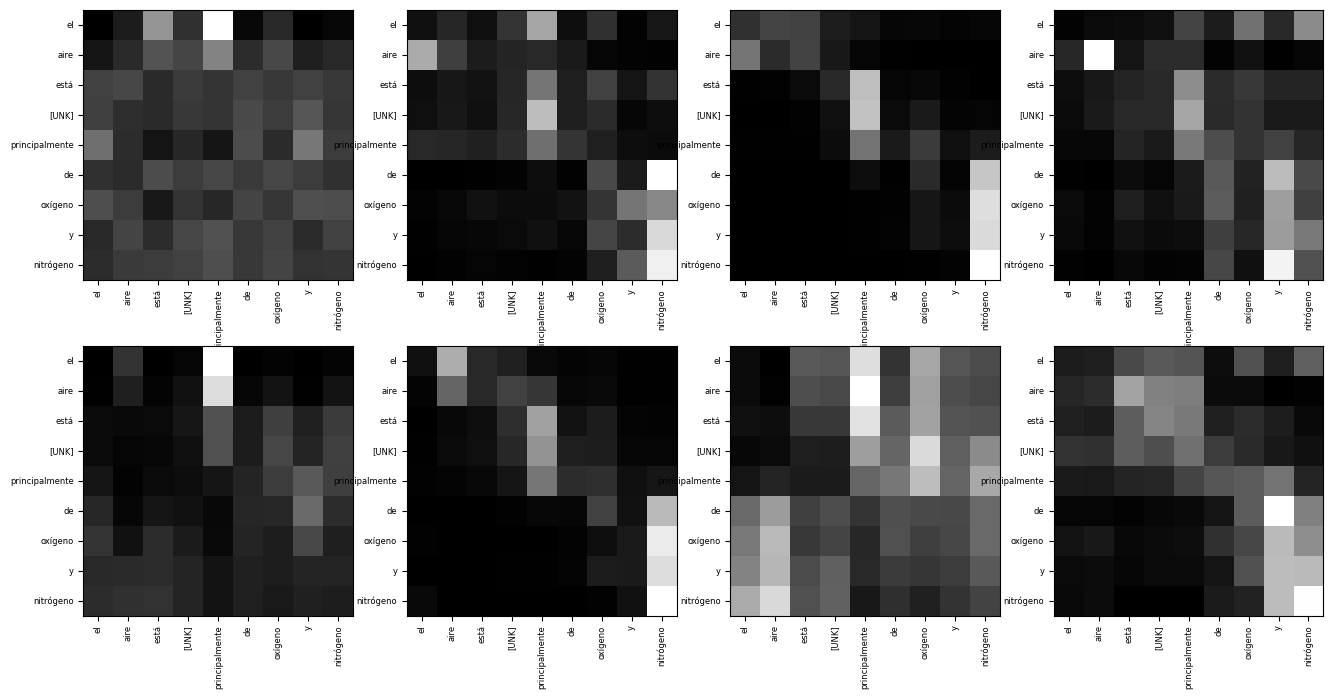

In [107]:
plt.figure(figsize=(16, 8))
for i in range(num_heads):
    # Display original
    ax = plt.subplot(2, num_heads//2, i + 1)
    plt.imshow(encoder_attantion[1][0,i,:9,:9].numpy())
    plt.gray()
    ax.set_xticks(range(9))
    ax.set_yticks(range(9))
    ax.set_xticklabels(sample_keys[:9], rotation='vertical', fontsize=6)
    ax.set_yticklabels(sample_keys[:9], fontsize=6)
    ax.get_xaxis()
    ax.get_yaxis()

plt.show()

## Using a pre-trained embedding

You can try using a pre-trained embedding to help boost your model performance. The cells below download and prepare the Google NNLM Spanish embedding with normalization and embedding dimension of 50. The pre-trained embedding is loaded as a keras layer and can be passed to our Custom_Embedding layer to promote it to a positional embedding.

Note, the pre-trained embedding generates sequences of variable length, as such you need to modify the dataset to pad/truncate the embeddings to the desired sequence length.

In [ ]:
# Define a function to download a google NNLM model
def download_g_nnlm(nnlm_model: str):
    '''Downloads the NNLM model from Google's NNLM models on kaggle
    (https://www.kaggle.com/models/google/nnlm) where pretrained
    embedding models in multiple languages are available. You can
    choose the embedding dimension to be 50 or 128. Finally, you can
    choose models with or without text normalization to remove 
    punctuations.

    The downloaded model is moved to:
        home_dir/models/google_nnlm/lled(wn)
        ll: 2 letter abbreviation of the language (en, es, de,...)
        ed: embedding dimension (50 or 128)
        wn: with normalization
    '''
    # model specs
    model = nnlm_model.split('/')[-1]
    language = model.split('-')[0]
    embedding_dim = model.split('-')[1].split('dim')[-1]
    model_dir = f'{home_dir}/models/google_nnlm/{language}{embedding_dim}'
    if len(model.split('-'))>2:
        model_dir += '_wn'
    # Check if the model is on disk
    if os.path.exists(model_dir):
        print('Model is already on disk.')
        return None
    # download model
    path = kagglehub.model_download(nnlm_model, force_download=True)
    # Create model_dir
    os.mkdir(model_dir)
    # Move downloaded model to model_dir
    for dir, contents, files in os.walk(path):
        # Create sub-directory
        if not os.path.exists(model_dir+dir[len(path):]):
            os.mkdir(model_dir+dir[len(path):])
        # Move files
        for file in files:
            os.rename(dir+'/'+file, model_dir+dir[len(path):]+'/'+file)
    print('Model downloaded succesfully.')
    return None

In [ ]:
# Create a directory for google nnlm models
if not os.path.exists(home_dir+'/models/google_nnlm'):
    os.mkdir(home_dir+'/models/google_nnlm')

# Download Spanish text embedding model
download_g_nnlm("google/nnlm/tensorFlow2/es-dim50-with-normalization")

In [ ]:
# You can load the embedding model via:
#    hub.load(path) or tf.saved_model.load(path) as a tensorflow saved model.
#    hub.KerasLayer(path, input_shape=[], dtype=tf.string) as a keras layer.
embedding_es50wn = hub.KerasLayer(home_dir+'/models/google_nnlm/es50_wn')

num_embeddings_es50wn, embedding_dim_es50wn = embedding_es50wn.variables[0].shape

print(f'number of embedding vectors = {num_embeddings_es50wn}')
print(f'embedding dimension = {embedding_dim_es50wn}')